In [33]:

# [Cell 1] 数据加载与全局设置
# ---------------------------------------------------------
# 生成的变量: 
#   df_hist (历史数据: Year, PV_Capacity, Wind_Total, Onshore_Wind, Offshore_Wind)
#   df_anchors (IEA锚点数据: Year, IEA_Scenario, Wind_Scenario, PV_Capacity, Wind_Total)
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 图表样式设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.sans-serif': ['Arial', 'DejaVu Sans', 'SimHei'], 'axes.unicode_minus': False})

file_path = 'Source Data.xlsx'

# --- 1. 加载历史数据 ---
print("正在加载历史数据...")
df_capacity = pd.read_excel(file_path, sheet_name='Capacity', header=1)
df_hist = df_capacity.iloc[:, [0, 12, 13, 14, 15]].copy()
df_hist.columns = ['Year', 'PV_Capacity', 'Wind_Total', 'Onshore_Wind', 'Offshore_Wind']
df_hist['Year'] = df_hist['Year'].astype(int)

# --- 2. 加载 IEA 情景锚点数据 ---
print("正在加载 IEA 情景锚点数据...")
df_scenario = pd.read_excel(file_path, sheet_name='IEA Scenario', header=None)
anchor_data = []

# 解析所有有效行（从索引2开始）
for i in range(2, len(df_scenario)):
    try:
        row = df_scenario.iloc[i]
        yr = int(float(row[0]))
        scen_raw = str(row[1]).strip()
        pv = float(row[2])
        wind = float(row[3])
        
        # 解析情景名称
        if 'Baseline' in scen_raw:
            iea_scen, wind_scen = 'Baseline', 'Baseline'
        else:
            parts = scen_raw.split(' - ')
            if len(parts) == 2:
                wind_scen, iea_scen = parts[0].strip(), parts[1].strip()
            else:
                continue
                
        anchor_data.append({
            'Year': yr, 'Combined_Scenario': scen_raw,
            'IEA_Scenario': iea_scen, 'Wind_Scenario': wind_scen,
            'PV_Capacity': pv, 'Wind_Total': wind
        })
    except: pass

df_anchors = pd.DataFrame(anchor_data).drop_duplicates()
print(f"数据加载完成: {len(df_hist)} 条历史记录, {len(df_anchors)} 个锚点数据.")


正在加载历史数据...
正在加载 IEA 情景锚点数据...
数据加载完成: 19 条历史记录, 9 个锚点数据.


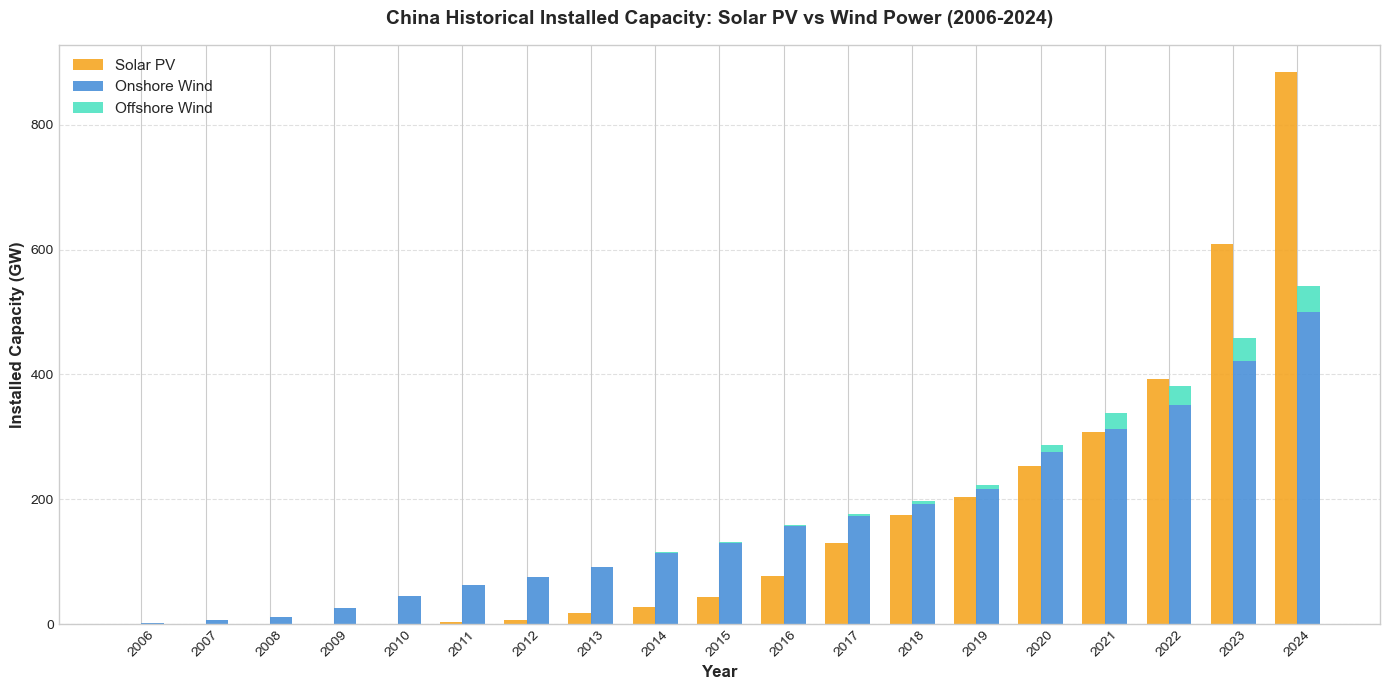

In [34]:

# [Cell 2] 历史数据可视化
# ---------------------------------------------------------
# 功能: 可视化 2006-2024 年的历史装机容量（分组柱状图）
# 使用变量: df_hist
# 输出: 光伏 vs 风电（堆叠陆上/海上）图表
# ---------------------------------------------------------

years = df_hist['Year'].values
x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))

# 光伏柱状图
ax.bar(x - width/2, df_hist['PV_Capacity'], width, label='Solar PV', color='#F5A623', alpha=0.9)

# 风电堆叠柱状图 (陆上 + 海上)
ax.bar(x + width/2, df_hist['Onshore_Wind'], width, label='Onshore Wind', color='#4A90D9', alpha=0.9)
ax.bar(x + width/2, df_hist['Offshore_Wind'], width, bottom=df_hist['Onshore_Wind'], label='Offshore Wind', color='#50E3C2', alpha=0.9)

# 图表格式设置
ax.set_xlabel('Year', fontsize=12, weight='bold')
ax.set_ylabel('Installed Capacity (GW)', fontsize=12, weight='bold')
ax.set_title('China Historical Installed Capacity: Solar PV vs Wind Power (2006-2024)', fontsize=14, weight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
# plt.savefig('historical_capacity_merged.png', dpi=150)
plt.show()


Starting Optimized Logistic Fitting...
预测结果已保存至 Excel.
Plotting Projections...


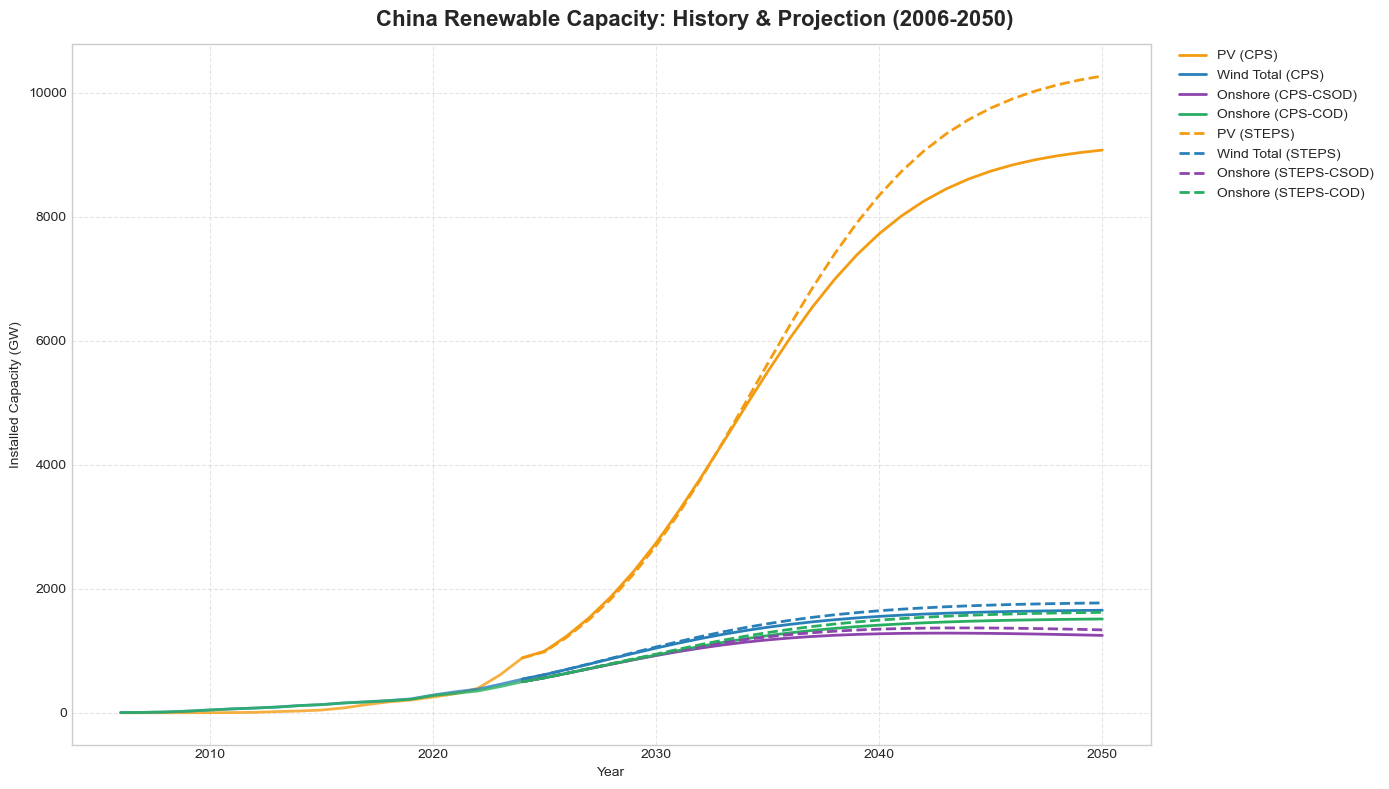

In [ ]:
# [Cell 3] Logistic 预测 (2025-2050) - Optimized & Visualized
# ---------------------------------------------------------
# 功能: 使用改进的 Logistic 拟合预测未来装机量并进行分组可视化
# 优化点: 
#   1. K (饱和值) 不再固定，设为可变参数，下限为 2050 Anchor * 1.1
#   2. 引入权重拟合：近5年 (2020-2024) 权重设为 10，优先拟合近期趋势
#   3. 可视化优化 (Final Layout)：
#      - 合并已显示 CPS(实线) 和 STEPS(虚线) 情景
#      - 颜色区分: PV(橙), Total Wind(蓝), Onshore-COD(绿), Onshore-CSOD(紫)
#      - 隐藏历史图例与节点黑点
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# --- 函数定义 ---
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def fit_logistic_optimized(years_hist, cap_hist, years_anc, cap_anc, K_min):
    all_years = np.concatenate([years_hist, years_anc])
    all_cap = np.concatenate([cap_hist, cap_anc])
    weights = np.ones(len(all_years))
    for i, y in enumerate(all_years):
        if y >= 2020 and y <= 2024: weights[i] = 10.0
    sigma = 1.0 / weights
    bounds = ([K_min, 0.05, 2010], [20000, 0.5, 2060])
    p0 = [K_min * 1.5, 0.15, 2030]
    try:
        popt, _ = curve_fit(logistic, all_years, all_cap, p0=p0, bounds=bounds, sigma=sigma, absolute_sigma=False, maxfev=20000)
        return popt[0], popt[1], popt[2]
    except: return K_min, 0.1, 2030

def get_offshore_share(year, wind_scenario):
    p2024 = 0.0761
    if year <= 2024: return p2024
    if wind_scenario == 'COD':
        p2030 = 0.1152
        if year <= 2030: return p2024 + (year - 2024) * (p2030 - p2024) / 6
        else: return p2030
    elif wind_scenario == 'CSOD':
        p2030, p2035, p2050 = 0.1152, 0.1478, 0.2455
        if year <= 2030: return p2024 + (year - 2024) * (p2030 - p2024) / 6
        elif year <= 2035: return p2030 + (year - 2030) * (p2035 - p2030) / 5
        else: return p2035 + (year - 2035) * (p2050 - p2035) / 15
    return 0

# --- 执行预测 ---
years_future = np.arange(2025, 2051)
results, fitting_params = [], []
target_scenarios = [('CPS', 'COD'), ('CPS', 'CSOD'), ('STEPS', 'COD'), ('STEPS', 'CSOD')]

print("Starting Optimized Logistic Fitting...")

for iea_scn, wind_scn in target_scenarios:
    full_scn_name = f"{iea_scn}-{wind_scn}"
    mask = (df_anchors['IEA_Scenario'] == 'Baseline') | ((df_anchors['IEA_Scenario'] == iea_scn) & (df_anchors['Wind_Scenario'] == wind_scn))
    curr_anchors = df_anchors[mask].sort_values('Year')
    
    row_2050 = curr_anchors[curr_anchors['Year'] == 2050]
    if len(row_2050) == 0: continue
    K_min_pv = row_2050['PV_Capacity'].values[0] * 1.1
    K_min_wind = row_2050['Wind_Total'].values[0] * 1.1
    
    K_pv, r_pv, t0_pv = fit_logistic_optimized(df_hist['Year'].values, df_hist['PV_Capacity'].values, curr_anchors['Year'].values, curr_anchors['PV_Capacity'].values, K_min_pv)
    K_wind, r_wind, t0_wind = fit_logistic_optimized(df_hist['Year'].values, df_hist['Wind_Total'].values, curr_anchors['Year'].values, curr_anchors['Wind_Total'].values, K_min_wind)
    
    fitting_params.append({'Scenario': full_scn_name, 'K_PV': K_pv, 'K_Wind': K_wind})
    
    for yr in years_future:
        pred_pv = logistic(yr, K_pv, r_pv, t0_pv)
        pred_wind = logistic(yr, K_wind, r_wind, t0_wind)
        share = get_offshore_share(yr, wind_scn)
        results.append({
            'Year': int(yr), 'Scenario': full_scn_name,
            'PV_Capacity': round(pred_pv, 2), 'Wind_Total': round(pred_wind, 2),
            'Onshore_Wind': round(pred_wind * (1-share), 2),
            'Offshore_Wind': round(pred_wind * share, 2)
        })

df_results = pd.DataFrame(results)
with pd.ExcelWriter(file_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Logistic_Projection', index=False)
print("预测结果已保存至 Excel.")

# --- 可视化 (Merged & Colors Updated) ---
print("Plotting Projections...")
fig, ax = plt.subplots(figsize=(14, 8))
fig.suptitle("China Renewable Capacity: History & Projection (2006-2050)", fontsize=16, weight='bold')

# 颜色映射
colors = {
    'PV': '#F39C12',       # Orange
    'Wind': '#2980B9',     # Blue
    'Onshore_COD': '#27AE60',  # Green
    'Onshore_CSOD': '#8E44AD'  # Purple
}
# 线型映射
scn_ls_map = {'CPS': '-', 'STEPS': '--'}

# 颜色浅化工具（用于阴影）
def lighten_color(color, amount=0.65):
    r, g, b = mcolors.to_rgb(color)
    return (r + (1 - r) * amount, g + (1 - g) * amount, b + (1 - b) * amount)

# 1. 绘制历史数据 (不带 Label)
hist_years = df_hist['Year']
hist_onshore = df_hist['Wind_Total'] - (df_hist['Offshore_Wind'] if 'Offshore_Wind' in df_hist.columns else 0)

ax.plot(hist_years, df_hist['PV_Capacity'], color=colors['PV'], lw=2, linestyle='-', alpha=0.8, zorder=3)
ax.fill_between(hist_years, 0, df_hist['PV_Capacity'], color=lighten_color(colors['PV']), alpha=0.08, linewidth=0, zorder=0)
ax.plot(hist_years, df_hist['Wind_Total'], color=colors['Wind'], lw=2, linestyle='-', alpha=0.8, zorder=3)
ax.fill_between(hist_years, 0, df_hist['Wind_Total'], color=lighten_color(colors['Wind']), alpha=0.06, linewidth=0, zorder=0)
ax.plot(hist_years, hist_onshore, color=colors['Onshore_COD'], lw=2, linestyle='-', alpha=0.8, zorder=3) # 历史Onshore默认用COD色
ax.fill_between(hist_years, 0, hist_onshore, color=lighten_color(colors['Onshore_COD']), alpha=0.06, linewidth=0, zorder=0)

# 获取2024节点值用于衔接，去掉了黑点标记
val_pv_2024 = df_hist[df_hist['Year']==2024]['PV_Capacity'].values[0]
val_wind_2024 = df_hist[df_hist['Year']==2024]['Wind_Total'].values[0]
val_on_2024 = hist_onshore[df_hist['Year']==2024].values[0]

# 2. 绘制预测数据
scenarios = ['CPS', 'STEPS']
onshore_variants = ['CSOD', 'COD']

for main_scn in scenarios:
    ls = scn_ls_map[main_scn]
    # PV & Total Wind
    # 使用 CSOD 作为基础数据
    base_data = df_results[df_results['Scenario'] == f"{main_scn}-CSOD"]
    if base_data.empty: continue
    
    plot_years = np.concatenate(([2024], base_data['Year'].values))

    # PV
    plot_pv = np.concatenate(([val_pv_2024], base_data['PV_Capacity'].values))
    ax.plot(plot_years, plot_pv, c=colors['PV'], linestyle=ls, lw=2, zorder=3, label=f'PV ({main_scn})')
    ax.fill_between(plot_years, 0, plot_pv, color=lighten_color(colors['PV']), alpha=0.22, linewidth=0, zorder=1)
    
    # Wind Total
    plot_wind = np.concatenate(([val_wind_2024], base_data['Wind_Total'].values))
    ax.plot(plot_years, plot_wind, c=colors['Wind'], linestyle=ls, lw=2, zorder=3, label=f'Wind Total ({main_scn})')
    ax.fill_between(plot_years, 0, plot_wind, color=lighten_color(colors['Wind']), alpha=0.18, linewidth=0, zorder=1)
    
    # Onshore Variants
    for vart in onshore_variants:
        d = df_results[df_results['Scenario'] == f"{main_scn}-{vart}"]
        if d.empty: continue
        
        plot_on = np.concatenate(([val_on_2024], d['Onshore_Wind'].values))
        
        # Color depends on COD vs CSOD
        col = colors[f'Onshore_{vart}']
        
        ax.plot(plot_years, plot_on, c=col, linestyle=ls, lw=2, zorder=3, label=f'Onshore ({main_scn}-{vart})')
        ax.fill_between(plot_years, 0, plot_on, color=lighten_color(col), alpha=0.16, linewidth=0, zorder=1)

ax.set_xlabel('Year')
ax.set_ylabel('Installed Capacity (GW)')
ax.grid(True, linestyle='--', alpha=0.5)
# Legend
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


MFA Results (with Cumulative columns) saved to sheet 'PV_MFA_Results'.


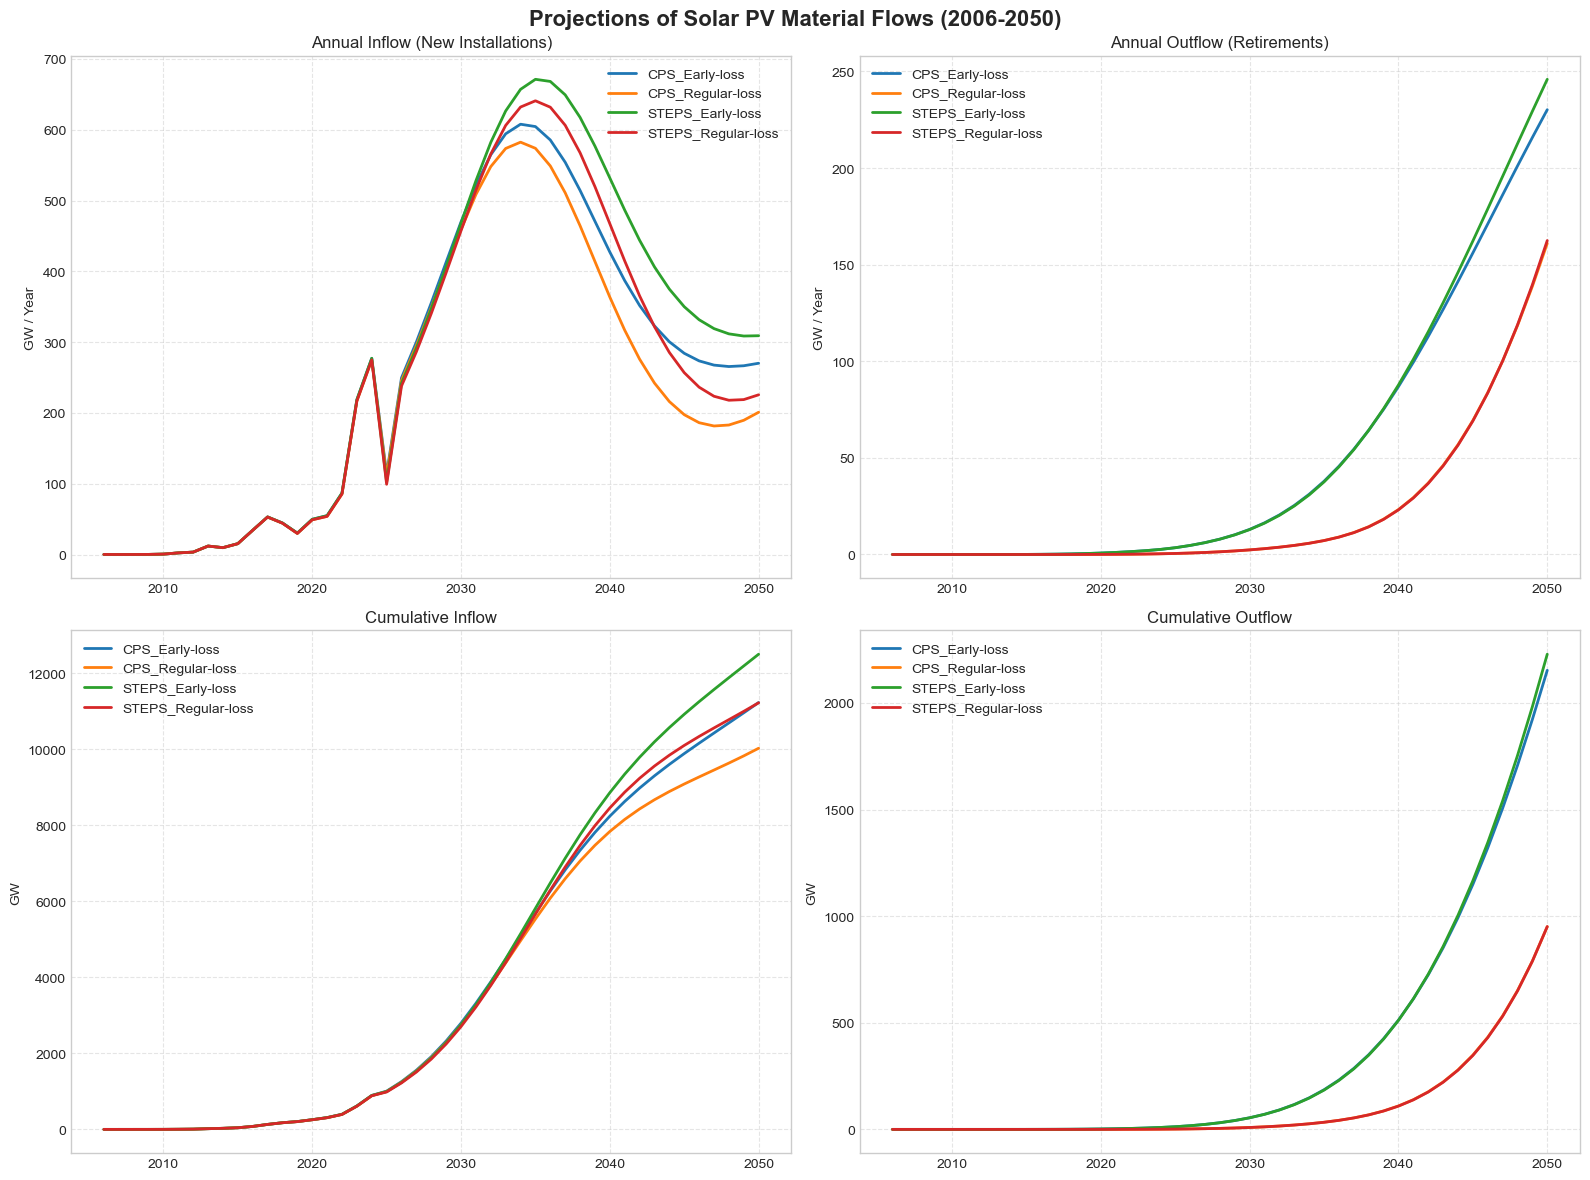

In [36]:
# [Cell 4] PV MFA Analysis: Inflow, Outflow & Stock (Stock-Driven Model)
# ---------------------------------------------------------
# 功能: 基于历史和预测的存量数据，结合不同的寿命分布 (Early/Regular)，计算每年新增和退役量
# 输入: Source Data.xlsx (Capacity, Logistic_Projection, Weibull_Params)
# 输出: Source Data.xlsx (PV_MFA_Results), 4张可视化图表
# 情景组合: 
#   1. CPS - Early-loss
#   2. CPS - Regular-loss
#   3. STEPS - Early-loss
#   4. STEPS - Regular-loss
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Weibull（无 scipy 依赖）：
# CDF(x) = 1 - exp(-(x/alpha)^beta)
# PDF(x) = (beta/alpha) * (x/alpha)^(beta-1) * exp(-(x/alpha)^beta)
def weibull_cdf(x, beta, alpha):
    x = np.asarray(x, dtype=float)
    x = np.maximum(x, 0.0)
    return 1.0 - np.exp(-np.power(x / alpha, beta))

def weibull_pdf(x, beta, alpha):
    x = np.asarray(x, dtype=float)
    x = np.maximum(x, 0.0)
    z = x / alpha
    return (beta / alpha) * np.power(z, beta - 1.0) * np.exp(-np.power(z, beta))

# --- 1. 数据准备 ---
file_path = 'Source Data.xlsx'

# 读取参数
df_params = pd.read_excel(file_path, sheet_name='Weibull_Params')
# 读取预测数据
df_proj = pd.read_excel(file_path, sheet_name='Logistic_Projection')
# 读取历史据 (复用 df_hist, 如果未定义则重新读取)
try:
    df_hist_use = df_hist[['Year', 'PV_Capacity']].copy()
except NameError:
    df_cap = pd.read_excel(file_path, sheet_name='Capacity', header=1)
    df_hist_use = df_cap.iloc[:, [0, 12]].copy()
    df_hist_use.columns = ['Year', 'PV_Capacity']
    df_hist_use['Year'] = df_hist_use['Year'].astype(int)

# --- 2. 辅助函数 ---

def get_weibull_params(year, loss_type, params_table):
    # 根据安装年份和类型获取 Alpha (scale) 和 Beta (shape)
    # 这里约定: Beta=shape, Alpha=scale
    row = params_table[(params_table['Start_Year'] <= year) & 
                       (params_table['End_Year'] >= year) & 
                       (params_table['Type'] == loss_type)]
    if not row.empty:
        return row.iloc[0]['Beta'], row.iloc[0]['Alpha']
    return 2.5, 30.0 # Default fallback

def calculate_flows(target_years, target_stock, loss_type, params_table):
    # 计算方式（与“累计退役概率差 × 安装年总新增量”的 cohort 方法一致）：
    #   对于安装年 i，在分析年 t 的退役比例 = CDF(age) - CDF(age-1)
    #   Outflow(t) = Σ[ Inflow(i) * (CDF(t-i) - CDF(t-i-1)) ]
    # 同时使用 stock-driven 守恒关系回推当年总新增量（含替换/推移量）：
    #   Inflow(t) = (Stock(t) - Stock(t-1)) + Outflow(t)
    
    years = np.array(target_years)
    stock = np.array(target_stock)
    n_years = len(years)
    
    inflows = np.zeros(n_years)   # 当年总新增量（=预测新增量 + 推移/替换量）
    outflows = np.zeros(n_years)  # 当年退役量
    
    # 假设初始年份前无库存，或初始年份Inflow = Stock
    inflows[0] = stock[0] 
    
    for t in range(1, n_years):
        current_year = years[t]
        
        # 1. 计算当年的退役量：对所有安装年 cohort 做 CDF 差分
        outflow_sum = 0
        for i in range(t):
            install_year = years[i]
            age = current_year - install_year
            
            # 获取该安装年份对应的参数
            shape, scale = get_weibull_params(install_year, loss_type, params_table)
            
            # discrete retirement probability: CDF(age) - CDF(age-1)
            p_fail = weibull_cdf(age, shape, scale) - weibull_cdf(age - 1, shape, scale)
            
            outflow_sum += inflows[i] * p_fail
            
        outflows[t] = outflow_sum
        
        # 2. 质量守恒计算 Inflow
        delta_stock = stock[t] - stock[t-1]
        calc_inflow = delta_stock + outflows[t]
        
        # 避免负流入 (由于数据去噪或小幅波动可能导致，实际应设为0)
        inflows[t] = max(0, calc_inflow)
        
    return inflows, outflows

# --- 3. 构建全时间序列情景 ---
start_year = 2006
end_year = 2050
full_years = np.arange(start_year, end_year + 1)

# 基础历史部分 (2006-2024)
hist_part = df_hist_use[(df_hist_use['Year'] >= start_year) & (df_hist_use['Year'] <= 2024)].sort_values('Year')
# 填补历史缺失年份（如果有）
hist_part = (hist_part.set_index('Year')
             .reindex(np.arange(start_year, 2025))
             .interpolate(method='linear') # 简单插值处理缺失
             .reset_index())

# 定义两个容量路径 (CPS, STEPS)
scenarios_cap = {}

# 提取 CPS 预测 (2025-2050)
# Projection表中 'Scenario' 列为 'CPS-COD' 等，PV数据对于 COD/CSOD 是一样的
proj_cps = df_proj[df_proj['Scenario'] == 'CPS-COD'][['Year', 'PV_Capacity']]
scenarios_cap['CPS'] = pd.concat([hist_part, proj_cps]).sort_values('Year')['PV_Capacity'].values

# 提取 STEPS 预测
proj_steps = df_proj[df_proj['Scenario'] == 'STEPS-COD'][['Year', 'PV_Capacity']]
scenarios_cap['STEPS'] = pd.concat([hist_part, proj_steps]).sort_values('Year')['PV_Capacity'].values

# 定义损失情景
loss_types = ['Early-loss', 'Regular-loss']

# --- 4. 循环计算 ---
results_all = []

for cap_scn, stock_data in scenarios_cap.items():
    for loss_scn in loss_types:
        full_name = f"{cap_scn}_{loss_scn}"
        
        inflows, outflows = calculate_flows(full_years, stock_data, loss_scn, df_params)
        
        # 收集结果
        for i, yr in enumerate(full_years):
            results_all.append({
                'Scenario': full_name,
                'Year': yr,
                'Inflow': inflows[i],
                'Outflow': outflows[i],
                'Stock': stock_data[i]
            })

df_results = pd.DataFrame(results_all)

# --- 新增：计算累积量 ---
df_results['Cumulative_Inflow'] = df_results.groupby('Scenario')['Inflow'].cumsum()
df_results['Cumulative_Outflow'] = df_results.groupby('Scenario')['Outflow'].cumsum()

# --- 5. 数据导出 ---
# 先删除可能存在的旧表 'PV_Inflow', 'PV_Outflow'
with pd.ExcelWriter(file_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
    # 如果需要删除sheet，openpyxl writer 模式下并不直接支持 drop sheet。
    # 'if_sheet_exists="replace"' 会覆盖同名。
    # 我们创建一个新表 'PV_MFA_Results'
    df_results.to_excel(writer, sheet_name='PV_MFA_Results', index=False)
    
# 尝试清理旧表 (需要加载workbook进行操作)
try:
    import openpyxl
    wb = openpyxl.load_workbook(file_path)
    changed = False
    for old_s in ['PV_Inflow', 'PV_Outflow']:
        if old_s in wb.sheetnames:
            del wb[old_s]
            changed = True
    if changed:
        wb.save(file_path)
        print("Old sheets deleted.")
except Exception as e:
    print(f"Sheet cleanup warning: {e}")

print("MFA Results (with Cumulative columns) saved to sheet 'PV_MFA_Results'.")

# --- 6. 可视化 (4张图) ---
# 准备绘图数据
def get_data(scn_name):
    return df_results[df_results['Scenario'] == scn_name]

scenarios_list = ['CPS_Early-loss', 'CPS_Regular-loss', 'STEPS_Early-loss', 'STEPS_Regular-loss']
# 颜色区分 CPS/STEPS；线型区分 Early/Regular
cap_colors = {'CPS': '#E74C3C', 'STEPS': '#F39C12'}
loss_styles = {'Early-loss': '-', 'Regular-loss': '--'}

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle('Projections of Solar PV Material Flows (2006-2050)', fontsize=16, weight='bold')

# 1. Annual Inflow
ax = axes[0, 0]
ax.set_title("Annual Inflow (New Installations)")
for name in scenarios_list:
    cap_scn, loss_scn = name.split('_', 1)
    d = get_data(name)
    ax.plot(d['Year'], d['Inflow'], label=name, lw=2, color=cap_colors[cap_scn], linestyle=loss_styles[loss_scn])
ax.set_ylabel('GW / Year'); ax.legend(); ax.grid(ls='--', alpha=0.5)

# 2. Annual Outflow
ax = axes[0, 1]
ax.set_title("Annual Outflow (Retirements)")
for name in scenarios_list:
    cap_scn, loss_scn = name.split('_', 1)
    d = get_data(name)
    ax.plot(d['Year'], d['Outflow'], label=name, lw=2, color=cap_colors[cap_scn], linestyle=loss_styles[loss_scn])
ax.set_ylabel('GW / Year'); ax.legend(); ax.grid(ls='--', alpha=0.5)

# 3. Cumulative Inflow (使用新列)
ax = axes[1, 0]
ax.set_title("Cumulative Inflow")
for name in scenarios_list:
    cap_scn, loss_scn = name.split('_', 1)
    d = get_data(name)
    ax.plot(d['Year'], d['Cumulative_Inflow'], label=name, lw=2, color=cap_colors[cap_scn], linestyle=loss_styles[loss_scn])
ax.set_ylabel('GW'); ax.legend(); ax.grid(ls='--', alpha=0.5)

# 4. Cumulative Outflow (使用新列)
ax = axes[1, 1]
ax.set_title("Cumulative Outflow")
for name in scenarios_list:
    cap_scn, loss_scn = name.split('_', 1)
    d = get_data(name)
    ax.plot(d['Year'], d['Cumulative_Outflow'], label=name, lw=2, color=cap_colors[cap_scn], linestyle=loss_styles[loss_scn])
ax.set_ylabel('GW'); ax.legend(); ax.grid(ls='--', alpha=0.5)

# 5. Weibull PDF curves (bottom-left)
ax = axes[2, 0]
ax.set_title('Weibull PDFs (Lifetime Distributions)')
ages = np.linspace(0, 60, 601)

# 2013以前（用 2013 代表），2014以后（用 2014 代表）
b1e, a1e = get_weibull_params(2013, 'Early-loss', df_params)
b1r, a1r = get_weibull_params(2013, 'Regular-loss', df_params)
b2e, a2e = get_weibull_params(2014, 'Early-loss', df_params)
b2r, a2r = get_weibull_params(2014, 'Regular-loss', df_params)

ax.plot(ages, weibull_pdf(ages, b1e, a1e), lw=2, label=f'<=2013 Early (α={a1e:g}, β={b1e:g})')
ax.plot(ages, weibull_pdf(ages, b1r, a1r), lw=2, label=f'<=2013 Regular (α={a1r:g}, β={b1r:g})')
ax.plot(ages, weibull_pdf(ages, b2e, a2e), lw=2, label=f'>=2014 Early (α={a2e:g}, β={b2e:g})')
ax.plot(ages, weibull_pdf(ages, b2r, a2r), lw=2, label=f'>=2014 Regular (α={a2r:g}, β={b2r:g})')

ax.set_xlabel('Age (years)')
ax.set_ylabel('Probability Density')
ax.grid(ls='--', alpha=0.5)
ax.legend(fontsize=9)

# bottom-right 留空
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# [Cell 5] 生成寿命样本（退役 + 在役右删失）
# ---------------------------------------------------------
# 退役样本（Afmeldte-Decommissioned）：duration_years = (decommission_date - connection_date).days / 365
# 在役样本（IkkeAfmeldte-Existing turbines）：按截止日做右删失 duration_years = (censor_date - connection_date).days / 365
# 写入 anlaeg.xlsx（避免后续反复计算）：
# - retirement_duration_years：退役寿命样本（1列 duration_years）
# - active_censored_duration_years：在役右删失样本（1列 duration_years）
# ---------------------------------------------------------

from pathlib import Path
import pandas as pd

xlsx_path = Path('anlaeg.xlsx')
if not xlsx_path.exists():
    raise FileNotFoundError("anlaeg.xlsx not found. 请先下载/放置 anlaeg.xlsx 到当前目录。")

CENSOR_DATE = '2022-01-31'

# 退役：Afmeldte-Decommissioned
df_ret = pd.read_excel(
    xlsx_path,
    sheet_name='Afmeldte-Decommissioned',
    header=17,
    usecols=['Dato for oprindelig nettilslutning', 'Dato for afmeldning'],
)
conn = pd.to_datetime(df_ret['Dato for oprindelig nettilslutning'], errors='coerce')
decom = pd.to_datetime(df_ret['Dato for afmeldning'], errors='coerce')
dur_ret = ((decom - conn).dt.days / 365.0).dropna()
dur_ret = dur_ret[dur_ret >= 0]

# 在役：IkkeAfmeldte-Existing turbines（右删失到 CENSOR_DATE）
df_act = pd.read_excel(
    xlsx_path,
    sheet_name='IkkeAfmeldte-Existing turbines',
    header=17,
    usecols=['Dato for oprindelig nettilslutning'],
)
conn_a = pd.to_datetime(df_act['Dato for oprindelig nettilslutning'], errors='coerce')
c = pd.Timestamp(CENSOR_DATE)
dur_cens = ((c - conn_a).dt.days / 365.0).dropna()
dur_cens = dur_cens[dur_cens >= 0]

out_ret = pd.DataFrame({'duration_years': dur_ret.astype(float).to_numpy()})
out_cens = pd.DataFrame({'duration_years': dur_cens.astype(float).to_numpy()})

with pd.ExcelWriter(xlsx_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    out_ret.to_excel(writer, sheet_name='retirement_duration_years', index=False)
    out_cens.to_excel(writer, sheet_name='active_censored_duration_years', index=False)

print('Saved sheets: retirement_duration_years / active_censored_duration_years')
print('retired_n:', len(out_ret), 'active_censored_n:', len(out_cens), 'censor_date:', CENSOR_DATE)


In [ ]:
# [Cell 6] 用寿命样本拟合 Weibull（可含右删失）
# ---------------------------------------------------------
# 依赖 Cell 5 生成的两个 sheet：
# - retirement_duration_years（事件样本）
# - active_censored_duration_years（右删失样本，可选）
# ---------------------------------------------------------

from pathlib import Path
import numpy as np
import pandas as pd

xlsx_path = Path('anlaeg.xlsx')
if not xlsx_path.exists():
    raise FileNotFoundError('anlaeg.xlsx not found. 请先下载/放置 anlaeg.xlsx 到当前目录。')

USE_CENSORING = True
PLOT = True

def read_duration(sheet: str) -> np.ndarray:
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    if 'duration_years' not in df.columns:
        raise ValueError(f"Sheet {sheet} missing column duration_years")
    x = pd.to_numeric(df['duration_years'], errors='coerce').dropna().astype(float).to_numpy()
    x = x[np.isfinite(x)]
    return x[x > 0]

retired = read_duration('retirement_duration_years')
censored = None
if USE_CENSORING:
    try:
        censored = read_duration('active_censored_duration_years')
    except Exception:
        censored = None

def weibull_pdf(t, beta, alpha):
    t = np.asarray(t, dtype=float)
    z = t / alpha
    return (beta / alpha) * np.power(z, beta - 1.0) * np.exp(-np.power(z, beta))

def alpha_mle_given_beta(t, beta):
    return float(np.power(np.mean(np.power(t, beta)), 1.0 / beta))

def nll_beta_uncensored(beta, t):
    beta = float(beta)
    if beta <= 0:
        return 1e18
    alpha = alpha_mle_given_beta(t, beta)
    n = t.size
    ll = n * np.log(beta) - n * beta * np.log(alpha) + (beta - 1.0) * np.sum(np.log(t)) - n
    return float(-ll)

def fit_uncensored(t):
    try:
        from scipy.optimize import minimize_scalar
        res = minimize_scalar(lambda b: nll_beta_uncensored(b, t), bounds=(0.2, 20.0), method='bounded')
        beta = float(res.x)
    except Exception:
        betas = np.linspace(0.5, 10.0, 2000)
        beta = float(betas[int(np.argmin([nll_beta_uncensored(b, t) for b in betas]))])
    return beta, alpha_mle_given_beta(t, beta)

def nll_censored(theta, t_event, t_cens):
    beta, alpha = float(theta[0]), float(theta[1])
    if beta <= 0 or alpha <= 0:
        return 1e18
    z_e = t_event / alpha
    ll_e = (
        t_event.size * (np.log(beta) - np.log(alpha))
        + (beta - 1.0) * np.sum(np.log(z_e))
        - np.sum(np.power(z_e, beta))
    )
    z_c = t_cens / alpha
    ll_c = -np.sum(np.power(z_c, beta))
    return float(-(ll_e + ll_c))

def fit_censored(t_event, t_cens, x0):
    try:
        from scipy.optimize import minimize
        res = minimize(lambda th: nll_censored(th, t_event, t_cens), x0=np.array(x0, dtype=float), bounds=[(1e-6, None), (1e-6, None)])
        return float(res.x[0]), float(res.x[1])
    except Exception:
        beta0, alpha0 = x0
        beta_grid = np.linspace(max(0.2, beta0 * 0.6), beta0 * 1.4, 180)
        alpha_grid = np.linspace(max(1.0, alpha0 * 0.6), alpha0 * 1.4, 180)
        best = (1e18, None, None)
        for beta in beta_grid:
            for alpha in alpha_grid:
                v = nll_censored((beta, alpha), t_event, t_cens)
                if v < best[0]:
                    best = (v, beta, alpha)
        return float(best[1]), float(best[2])

beta_u, alpha_u = fit_uncensored(retired)
print('[retired only] beta=', beta_u, 'alpha=', alpha_u, 'n=', len(retired))

if USE_CENSORING and censored is not None and len(censored) > 0:
    beta_c, alpha_c = fit_censored(retired, censored, x0=(beta_u, alpha_u))
    print('[with censoring] beta=', beta_c, 'alpha=', alpha_c, 'retired_n=', len(retired), 'censored_n=', len(censored))

if PLOT:
    try:
        import matplotlib.pyplot as plt

        def weibull_sf(t, beta, alpha):
            t = np.asarray(t, dtype=float)
            return np.exp(-np.power(t / alpha, beta))

        def km_survival(t_event, t_cens):
            # 简单 Kaplan–Meier（右删失）实现：返回 step 曲线 (times, S)
            t_event = np.asarray(t_event, dtype=float)
            t_cens = np.asarray(t_cens, dtype=float)
            times = np.unique(np.concatenate([t_event, t_cens]))
            # risk set / events / censored counts at each time
            n_at_risk = t_event.size + t_cens.size
            S = 1.0
            out_t = [0.0]
            out_S = [1.0]
            for tt in np.sort(times):
                d = int(np.sum(t_event == tt))
                c = int(np.sum(t_cens == tt))
                if n_at_risk <= 0:
                    break
                if d > 0:
                    S *= (1.0 - d / n_at_risk)
                    out_t.append(float(tt))
                    out_S.append(float(S))
                n_at_risk -= (d + c)
            return np.array(out_t), np.array(out_S)

        t_max = max(retired.max(), (censored.max() if censored is not None and len(censored) else 0))
        x = np.linspace(0, t_max * 1.05, 500)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # (1) PDF / Histogram
        ax = axes[0]
        ax.hist(retired, bins=60*4, density=True, alpha=0.35, color='gray', label=f'Retired (n={len(retired)})')
        ax.plot(x, weibull_pdf(x, beta_u, alpha_u), lw=2, label=f'Fit retired: β={beta_u:.2f}, α={alpha_u:.2f}')
        if USE_CENSORING and censored is not None and len(censored) > 0:
            ax.plot(x, weibull_pdf(x, beta_c, alpha_c), lw=2, ls='--', label=f'Fit censored: β={beta_c:.2f}, α={alpha_c:.2f}')
        ax.set_title('Lifetime Density')
        ax.set_xlabel('Lifespan (years)')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # (2) Survival
        ax = axes[1]

        # Empirical survival (retired only)
        t_sorted = np.sort(retired)
        emp_t = np.concatenate([[0.0], t_sorted])
        emp_S = np.concatenate([[1.0], 1.0 - (np.arange(1, len(t_sorted) + 1) / len(t_sorted))])
        ax.step(emp_t, emp_S, where='post', lw=2, color='lightgray', label='Empirical S(t) (retired only)')

        # Kaplan–Meier with censoring (retired + active right-censored)
        if USE_CENSORING and censored is not None and len(censored) > 0:
            km_t, km_S = km_survival(retired, censored)
            ax.step(km_t, km_S, where='post', lw=2, color='gray', label='Kaplan–Meier (retired + censored)')

        ax.plot(x, weibull_sf(x, beta_u, alpha_u), lw=2, label='Weibull S(t) (retired fit)')
        if USE_CENSORING and censored is not None and len(censored) > 0:
            ax.plot(x, weibull_sf(x, beta_c, alpha_c), lw=2, ls='--', label='Weibull S(t) (censored fit)')
        ax.set_title('Survival Function')
        ax.set_xlabel('t (years)')
        ax.set_ylabel('S(t)')
        ax.set_ylim(0, 1.02)
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Plot skipped:', e)


In [ ]:
# [Cell 7] 读取 Weibull 参数并计算风电 MFA（Total/Onshore/Offshore）
# ---------------------------------------------------------
# 1) 从 Source Data.xlsx / Weibull_Params 读取两组风电 Weibull 参数：
#    - Categories='Wind Power'
#    - Type='Retirement'（仅退役拟合）与 Type='Overall'（含右删失拟合）
#
# 2) 使用两套分布计算风能逐年：Inflow / Outflow / Stock / 累积
#    - 退役不区分海上/陆上寿命（寿命一致）
#    - 先计算 Total Wind 的“推移量/替换量”（由退役量决定），再按上一年 Offshore/Onshore 存量比例拆分
#    - 产出 3 个 sheet：Wind_MFA_Total / Wind_MFA_Onshore / Wind_MFA_Offshore
#    - 情景 8 种：CPS,STEPS × COD,CSOD × {RD,OD}
#      其中 RD=Retirement 分布（实线），OD=Overall 分布（虚线）
# ---------------------------------------------------------

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source_path = Path('Source Data.xlsx')
if not source_path.exists():
    raise FileNotFoundError('Source Data.xlsx not found in current directory.')

# --- 0) 读取风电 Weibull 参数（仅从 Source Data.xlsx / Weibull_Params 读取） ---
df_params = pd.read_excel(source_path, sheet_name='Weibull_Params')
if 'Categories' not in df_params.columns:
    raise ValueError("Weibull_Params 缺少 'Categories' 列；请先在该表中加入 Wind Power 两行参数（Type=Retirement/Overall）。")

wind_rows = df_params[df_params['Categories'] == 'Wind Power']
params_wind = {}
for dist_key, tname in {'RD': 'Retirement', 'OD': 'Overall'}.items():
    row = wind_rows[wind_rows['Type'] == tname]
    if row.empty:
        raise ValueError(f"Weibull_Params 缺少 Wind Power / Type={tname} 的参数行")
    params_wind[dist_key] = (float(row.iloc[0]['Beta']), float(row.iloc[0]['Alpha']))

# --- 1) 构建风电存量路径（历史 2006-2024 + 预测 2025-2050） ---
start_year, end_year = 2006, 2050
full_years = np.arange(start_year, end_year + 1)

df_cap = pd.read_excel(source_path, sheet_name='Capacity', header=1)
df_hist_w = df_cap.iloc[:, [0, 13, 14, 15]].copy()
df_hist_w.columns = ['Year', 'Wind_Total', 'Onshore_Wind', 'Offshore_Wind']
df_hist_w['Year'] = df_hist_w['Year'].astype(int)
df_hist_w = df_hist_w[(df_hist_w['Year'] >= start_year) & (df_hist_w['Year'] <= 2024)].sort_values('Year')

df_hist_w = (df_hist_w.set_index('Year')
             .reindex(np.arange(start_year, 2025))
             .interpolate(method='linear')
             .reset_index())

df_proj = pd.read_excel(source_path, sheet_name='Logistic_Projection')

def build_stock_series(policy: str, variant: str):
    scn = f"{policy}-{variant}"
    proj = df_proj[df_proj['Scenario'] == scn][['Year', 'Wind_Total', 'Onshore_Wind', 'Offshore_Wind']].copy()
    proj = proj[(proj['Year'] >= 2025) & (proj['Year'] <= end_year)].sort_values('Year')
    df = pd.concat([df_hist_w, proj], ignore_index=True).sort_values('Year')
    df = df.set_index('Year').reindex(full_years).interpolate(method='linear').reset_index()
    return (
        df['Wind_Total'].to_numpy(dtype=float),
        df['Onshore_Wind'].to_numpy(dtype=float),
        df['Offshore_Wind'].to_numpy(dtype=float),
    )

# --- 3) Weibull cohort 退役与 stock-driven 流量 ---
def weibull_cdf(age, beta, alpha):
    age = np.asarray(age, dtype=float)
    age = np.maximum(age, 0.0)
    return 1.0 - np.exp(-np.power(age / alpha, beta))

def flows_from_stock(years, stock, beta, alpha):
    years = np.asarray(years, dtype=int)
    stock = np.asarray(stock, dtype=float)
    n = len(years)
    inflow = np.zeros(n, dtype=float)
    outflow = np.zeros(n, dtype=float)
    inflow[0] = stock[0]
    for t in range(1, n):
        ages = years[t] - years[:t]
        p = weibull_cdf(ages, beta, alpha) - weibull_cdf(ages - 1, beta, alpha)
        outflow[t] = float(np.sum(inflow[:t] * p))
        inflow[t] = (stock[t] - stock[t-1]) + outflow[t]
    return inflow, outflow

def split_on_off(years, stock_total, stock_on, stock_off, outflow_total):
    years = np.asarray(years, dtype=int)
    stock_total = np.asarray(stock_total, dtype=float)
    stock_on = np.asarray(stock_on, dtype=float)
    stock_off = np.asarray(stock_off, dtype=float)
    outflow_total = np.asarray(outflow_total, dtype=float)
    n = len(years)
    inflow_on = np.zeros(n, dtype=float)
    inflow_off = np.zeros(n, dtype=float)
    outflow_on = np.zeros(n, dtype=float)
    outflow_off = np.zeros(n, dtype=float)
    inflow_on[0] = stock_on[0]
    inflow_off[0] = stock_off[0]
    for t in range(1, n):
        tot_prev = stock_total[t-1]
        share_off = (stock_off[t-1] / tot_prev) if tot_prev > 0 else 0.0
        outflow_off[t] = outflow_total[t] * share_off
        outflow_on[t] = outflow_total[t] - outflow_off[t]
        inflow_on[t] = (stock_on[t] - stock_on[t-1]) + outflow_on[t]
        inflow_off[t] = (stock_off[t] - stock_off[t-1]) + outflow_off[t]
    return inflow_on, outflow_on, inflow_off, outflow_off

# --- 3) 批量计算 8 种情景，并写回 Excel ---
policies = ['CPS', 'STEPS']
variants = ['COD', 'CSOD']
dists = {
    'RD': params_wind['RD'],
    'OD': params_wind['OD'],
}
dist_ls = {'RD': '-', 'OD': '--'}

rows_total, rows_on, rows_off = [], [], []

for pol in policies:
    for var in variants:
        stock_total, stock_on, stock_off = build_stock_series(pol, var)
        for dist_key, (beta, alpha) in dists.items():
            scn = f"{pol}_{var}_{dist_key}"
            inflow_t, outflow_t = flows_from_stock(full_years, stock_total, beta, alpha)
            inflow_on, outflow_on, inflow_off, outflow_off = split_on_off(
                full_years, stock_total, stock_on, stock_off, outflow_t
            )

            for i, yr in enumerate(full_years):
                rows_total.append({'Scenario': scn, 'Year': int(yr), 'Inflow': inflow_t[i], 'Outflow': outflow_t[i], 'Stock': stock_total[i]})
                rows_on.append({'Scenario': scn, 'Year': int(yr), 'Inflow': inflow_on[i], 'Outflow': outflow_on[i], 'Stock': stock_on[i]})
                rows_off.append({'Scenario': scn, 'Year': int(yr), 'Inflow': inflow_off[i], 'Outflow': outflow_off[i], 'Stock': stock_off[i]})

df_w_total = pd.DataFrame(rows_total)
df_w_on = pd.DataFrame(rows_on)
df_w_off = pd.DataFrame(rows_off)

for df in (df_w_total, df_w_on, df_w_off):
    df['Cumulative_Inflow'] = df.groupby('Scenario')['Inflow'].cumsum()
    df['Cumulative_Outflow'] = df.groupby('Scenario')['Outflow'].cumsum()

with pd.ExcelWriter(source_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_w_total.to_excel(writer, sheet_name='Wind_MFA_Total', index=False)
    df_w_on.to_excel(writer, sheet_name='Wind_MFA_Onshore', index=False)
    df_w_off.to_excel(writer, sheet_name='Wind_MFA_Offshore', index=False)

print("Saved: Wind_MFA_Total/Onshore/Offshore")

# --- 5) 可视化：参照 PV，4 张图（Total Wind），每张图 8 条折线 ---
def _get(df, name):
    return df[df['Scenario'] == name].sort_values('Year')

base_colors = {
    ('CPS', 'COD'): '#E74C3C',
    ('CPS', 'CSOD'): '#C0392B',
    ('STEPS', 'COD'): '#F39C12',
    ('STEPS', 'CSOD'): '#D35400',
}

scenario_order = [
    ('CPS', 'COD', 'RD'), ('CPS', 'COD', 'OD'),
    ('CPS', 'CSOD', 'RD'), ('CPS', 'CSOD', 'OD'),
    ('STEPS', 'COD', 'RD'), ('STEPS', 'COD', 'OD'),
    ('STEPS', 'CSOD', 'RD'), ('STEPS', 'CSOD', 'OD'),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Projections of Wind Power Material Flows (Total, 2006-2050)', fontsize=16, weight='bold')

plots = [
    ('Annual Inflow (New Installations)', 'Inflow', 'GW / Year'),
    ('Annual Outflow (Retirements)', 'Outflow', 'GW / Year'),
    ('Cumulative Inflow', 'Cumulative_Inflow', 'GW'),
    ('Cumulative Outflow', 'Cumulative_Outflow', 'GW'),
]

for ax, (title, col, ylabel) in zip(axes.flatten(), plots):
    ax.set_title(title)
    for pol, var, dist_key in scenario_order:
        scn = f"{pol}_{var}_{dist_key}"
        d = _get(df_w_total, scn)
        ax.plot(
            d['Year'], d[col],
            lw=2,
            color=base_colors[(pol, var)],
            linestyle=dist_ls[dist_key],
            label=scn,
        )
    ax.set_ylabel(ylabel)
    ax.grid(ls='--', alpha=0.5)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
